> **Note:** In most sessions you will be solving exercises posed in a Jupyter notebook that looks like this one. Because you are cloning a Github repository that only we can push to, you should **NEVER EDIT** any of the files you pull from Github. Instead, what you should do, is either make a new notebook and write your solutions in there, or **make a copy of this notebook and save it somewhere else** on your computer, not inside the `sds` folder that you cloned, so you can write your answers in there. If you edit the notebook you pulled from Github, those edits (possible your solutions to the exercises) may be overwritten and lost the next time you pull from Github. This is important, so don't hesitate to ask if it is unclear.

# Exercise Set 1: Lending club

*February 5, 2019*

In this Exercise Set 1 we will investigate loan data from `Lending Club`. We will see how nested cross validation can be used  to compute a distribution of performance metrics for comparing different models. We will also try out bagging.

Below we provide some code that helps by downloading and cleaning the data. Note this takes around 1 min if you have fast internet.

In [1]:
# Note: there are three .zip files with letter = a,b,c. 
# To ensure the files download in reasonable time we 
# only work with the first of the three. If you have time
# you can modify this cell to download all three. 

import os
import requests

filenames = []
base_url = 'https://resources.lendingclub.com/'

letter = 'a'
filename = f'LoanStats3{letter}.csv.zip'
url = base_url+filename

if not os.path.exists(filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
filenames.append(filename)

The target we are going to predict is whether loan is repaid. This can be extracted from the `loan_status` below. Features names that we work with:

- **annual_inc**: The self-reported annual income provided by the borrower during registration.
- **dti**: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- **emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
- **grade**: LC assigned loan grade
- **home_ownership**: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
- **int_rate**: Interest Rate on the loan
- **term**: The number of payments on the loan. Values are in months and can be either 36 or 60.
- **verification_status**: Indicates if income was verified by LC, not verified, or if the income source was verified

Load and structure data

In [2]:
import numpy as np
import pandas as pd

# Read in csv files, store them
dfs = [pd.read_csv(f,header=0,skiprows=1,low_memory=False) for f in filenames]

# concatenate the dataframes (as standard there is only 1)
df = pd.concat(dfs)\
        .dropna(subset=['loan_amnt'])\
        .dropna(axis=1, how='all')

# View data
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,0.0,N,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,0.0,N,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,0.0,N,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,0.0,N,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,0.0,N,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Identify loans of interest
df = df.loc[df.loan_status.isin(['Fully Paid', 'Charged Off'])].copy()

# Clean up variables 
df['charged_off'] = (df.loan_status=='Charged Off').astype(int)
df['int_rate_f'] = df.int_rate.str[:-1].astype(float)
df['emp_length_f'] = df.emp_length\
                        .str.split(' ')\
                        .str[0].str[:2]\
                        .str.replace('<','0')\
                        .astype(float)

# label and features
y_var = 'charged_off'
X_vars = ['term', 'int_rate_f', 'grade', 'home_ownership', 'emp_length_f',
          'annual_inc', 'verification_status', 'dti']

# Create dummies
data = pd.get_dummies(df[X_vars+[y_var]], drop_first=True)\
        .dropna()\
        .reset_index(drop=True)\
        .astype(np.float64)\
        .loc[:2000]\
        .copy()

# View data
data.head()

,int_rate_f,emp_length_f,annual_inc,dti,charged_off,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified
0,10.65,10.0,24000.0,27.65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,15.27,0.0,30000.0,1.00,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,15.96,10.0,12252.0,8.72,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,13.49,10.0,49200.0,20.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,12.69,1.0,80000.0,17.94,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


Now let us split the data into test and training data. To do this we use the `StratifiedShuffleSplit` from scikit learn (read more about splitting methods [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py))

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state=3)

# These are the row indices of the stratified split
data_splits = list(sss.split(data[y_var], data[y_var]))

# Separate data in y,X
y = data[y_var]
X_vars_b = data.columns!=y_var
X = data.loc[:,X_vars_b]

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)
model.feature_importances_

array([0.13847806, 0.14324927, 0.25034479, 0.27987532, 0.03218296,
       0.00861433, 0.00906586, 0.01202478, 0.01299955, 0.01246237,
       0.00273081, 0.        , 0.        , 0.01357714, 0.02629044,
       0.02646682, 0.03163749])

<br>
<br>

## 1.1 Model validation

We start out with some basic concepts and our goal is to estimate and evaluate the logistic regression.


> **Ex. 1.1.1:** extract the first data split and construct features, target for train, test data.
>> *Hint:* `data_splits` is a list with 10 train-test pairs of randomly selected row indices. So the k'th element of `data_splits` contains a pair (train_idx, test_idx) identifying the k'th fold in the data.

In [7]:
train_idx, test_idx = data_splits[0]

y_train = y.loc[train_idx]
X_train = X.loc[train_idx]

y_test = y.loc[test_idx]
X_test = X.loc[test_idx]

> **Ex. 1.1.2:** estimate a logistic regression model on your training data. Then compute the overall accuracy and $F_1$ score for the default class *on the training data*.
>
>> **Note**: the code below implements a pipeline which standardizes the data by converting it into zero mean and unit standard deviation. We let `C=10**10` which corresponds to no regularization. Make sure you understand why each of these steps are important by looking up the scikit learn docs.
>
>> *Hint 2:* `sklearn` has these functions built-in and are named `f1_score`, `accuracy_score`. See Raschka pp. 189-193.

In [8]:
from sklearn.preprocessing import StandardScaler        # scales variables to be mean=0,sd=1
from sklearn.linear_model import LogisticRegression     # regression model
from sklearn.pipeline import Pipeline                   # For building our model pipeline

lr = Pipeline([('scale', StandardScaler()),
               ('clf', LogisticRegression(class_weight='balanced',C=10**10, solver = 'liblinear'))])

In [9]:
from sklearn.metrics import f1_score, accuracy_score

lr.fit(X_train,y_train)
y_p_tr = lr.predict(X_train)
acc_tr, f1_tr = accuracy_score(y_train, y_p_tr), f1_score(y_train, y_p_tr)
acc_tr, f1_tr

(0.6628571428571428, 0.4025316455696203)

> **Ex. 1.1.3:** Explain some advantages of computing the $F_1$ score vs. computing the overall accuracy.

F1_score is the harmonic mean of precision and recall. With unbalanced data accuracy has the undesired property of being high under a decision rule that always assigns the majority class. Consider e.g. a dataset with 100 observations, of which 5 are "good fish" and 95 "bad fish"; always predicting "bad fish" results in a 95% accuracy. Note that this is not the unique way to get 95% accuracy, we could also imagine a model that correctly identifies all 5 good fish, but mislabels 5 bad fish. To solve this problem we want a model-performance-metric that is not blind to class imbalance.

This is what the F1 score helps us with, it weights precision (how precisely our "good fish" label is being put on good fish) and recall (how many of total good fish we actually label "good fish"). 

> **Ex. 1.1.4:** Compute the *test set* accuracy and $F_1$ score. How does these compare to the results you got in exercise 1.1.3? 

In [10]:
y_p_ts = lr.predict(X_test)
acc_ts, f1_ts = accuracy_score(y_test, y_p_ts), f1_score(y_test, y_p_ts)
acc_ts, f1_ts

(0.627287853577371, 0.33727810650887574)

> **Ex. 1.1.5:** Explain why test set performance is often preferred to the training set performance.

To avoid overfitting

<br>

### Cross validation

We now turn to actually optimizing the model. We will use cross validation to perform the optimization.

> **Ex. 1.1.6:** Explain what the parameter `C` does in logistic regression. How do parameters change when `C` get smaller? Also explain what `penalty='l1'` will do for coefficients.
>> *Hint:* The documentation for scikit learn will tell you everything you need to know about their implementation of logistic regression.

Remember that we use parameter C as our regularization parameter. Parameter C = 1/λ.

Lambda (λ) controls the trade-off between allowing the model to increase it's complexity as much as it wants with trying to keep it simple. For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit) by assigning big values to the weights for each parameter. If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple.

Parameter C will work the other way around. For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we low the power of regularization which implies the model is allowed to increase it's complexity, and therefore, overfit the data.

> **Ex. 1.1.7:** Use cross validation on training set to estimate hyperparameters and then re-estimate model on training set. The set of $\lambda$ to be considered are $\{10^{-4},10^{-2},1,10^{2},10^{4}\}$. Is the model with optimized hyperparameters better than the non-optimized?
>
>> *Hint 1:* This procedure is implemented in `GridSearchCV`. You set `n_jobs=-1` to parallize computation. See Raschka pp. 186-187 for inspiration.
>
>> *Hint 2:* Consider using `np.logspace` for making the set of $\lambda$.m

In [11]:
from sklearn.model_selection import GridSearchCV

grid = np.logspace(-4,4,5)

lr_cv = GridSearchCV(estimator = lr,
                    param_grid = {'clf__C':grid},
                    n_jobs = -1,
                    cv = 3)

lr_cv.fit(X_train,y_train) #reestimating model on training data
y_p_ts_cv = lr_cv.predict(X_test) #validating model on test data

acc_ts_cv, f1_ts_cv = accuracy_score(y_test, y_p_ts_cv), f1_score(y_test, y_p_ts_cv)
acc_ts_cv, f1_ts_cv             

#the results are sligthlyt better with CV

(0.6339434276206323, 0.3373493975903615)

> **Ex. 1.1.8:** Apply nested resampling to compute a distribution of test scores with and without optimization. You should use `data_splits` which we defined initially and input all the data.
>
>> *Hint:* You can implement this using your code from Ex. 1.1.6 and combine it with `cross_val_score`. Note that `cv` input should use `data_splits`. See Raschka pp. 188-189 for inspiration. 


In [24]:
# Nested cross-validation is useful because the true error is almost unbiased relative to the test set
from sklearn.model_selection import cross_val_score

nested_cv_score_nonopt = []
nested_cv_score_opt = []


for train, test in data_splits:
    
    y_train = y.loc[train]
    X_train = X.loc[train]
    
    y_test = y.loc[test]
    X_test = X.loc[test]
    
    lr_nes_cv = GridSearchCV(estimator = lr,
                    param_grid = {"clf__C":grid},
                    scoring = "accuracy",
                    n_jobs = -1,
                    cv = sss)
    lr_nes_cv.fit(X_train, y_train)
    nested_cv_score_nonopt.append(lr_nes_cv.best_score_) #score of best performing model 
    
    
    scores = cross_val_score(lr_nes_cv, X_train, y_train, scoring="accuracy", cv=sss)
    nested_cv_score_opt.append(np.mean(scores))

> **Ex. 1.1.9:** Plot the distributions of the optimized vs. the non-optimized. What do you conclude about the performance difference?

<function matplotlib.pyplot.show(*args, **kw)>

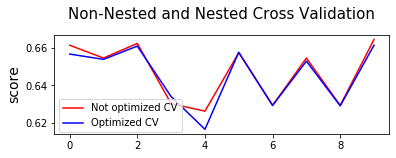

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(211)
nested_cv_score_nonopt_line, = plt.plot(nested_cv_score_nonopt, color='r')
nested_cv_score_opt_line, = plt.plot(nested_cv_score_opt, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Not optimized CV", "Optimized CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation",
          x=.5, y=1.1, fontsize="15")
plt.show

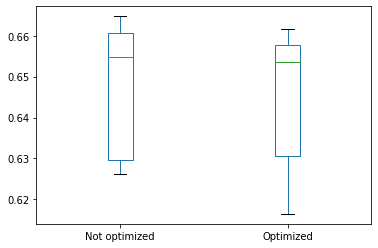

In [25]:
cv_res = pd.DataFrame({'Not optimized':nested_cv_score_nonopt, 
                       'Optimized':nested_cv_score_opt})
cv_res.plot.box()

>  **Ex. 1.1.10** Argue how $F_1$ differs from  *area under the curve* (AUC). Comment on their theoretical properties.

### Classification trees and forests

>  **Ex. 1.1.11** Estimate a classification tree on the training data (with default hyperparameters). Evalate both on training and test data by computing the *area under the curve*.
>
>> *Hint:* You can check out code for Ex. 1.1.10 for inspiration. You may also want to look up `roc_auc_score`.

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

model = RandomForestClassifier()
model.fit(X_train, y_train)

roc_auc_score(y_test, model.predict(X_test))

0.5158916341897158

>  **Ex. 1.1.12** Estimate 50 classification trees and compute the mean prediction. Use the mean prediction to compute the *area under the curve*.
>
>> *Hint:* You may use the code block below and apply it repeatedly.

In [29]:
from sklearn.tree import DecisionTreeClassifier

def train_tree(data_train):
    '''
    Trains a decision tree on a bootstrap 
    of training data.
    '''
    df_ = data_train.sample(frac=1, replace=True)
    ct = DecisionTreeClassifier(class_weight='balanced')
    ct.fit(df_.loc[:,X_vars_b], df_[y_var])
    return ct


In [37]:
num_trees = 50
data_train = data.loc[train_idx,:]
ct = []


for i in range(num_trees):
    ct.append(train_tree(data_train))

    # For both train and test do:
for label, idxs in [('train', train_idx), ('test', test_idx)]:
    
    # 0s with shape n-samples x n-models
    y_p_CT_ = np.zeros((idxs.shape[0], len(ct)))
    
    # For each model index
    for i in range(len(ct)):
        # Store models predicted values in the 0-matrix
        y_p_CT_[:,i] = ct[i].predict(X.loc[idxs])
    # print average AUC
    print(roc_auc_score(y_p_CT_.mean(1)>.2, y.loc[idxs]))

0.9480286738351255
0.546279871889628


>  **Ex. 1.1.13** Is Random Forest classification different from the procedure of aggregating tree predictions above? If so, explain how.

Yes they are different. RF also bootstraps which features to use; this is called feature bagging.